<a href="https://colab.research.google.com/github/melikas/SnapLife/blob/main/Snaplife.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np

# --- 0. Load the CSV files ---
# فقط فایل ساعتی بارگذاری می‌شود
df_hourly = pd.read_csv('hourly_fitbit_sema_df_unprocessed.csv', index_col=0)
df_sleep = pd.read_csv('csv-sleep ratio-hourly.csv', index_col=0)

# --- 1. Simplify 'id' to 'pidX' ---
# Get unique IDs and map them to pid1, pid2, etc.
unique_ids = df_hourly['id'].unique()
id_mapping = {id_val: f'pid{i+1}' for i, id_val in enumerate(unique_ids)}
df_hourly['pid'] = df_hourly['id'].map(id_mapping)

# --- 2. Combine 'date' and 'hour' into 'time' in hourly data ---
# Create a string time column for conversion to datetime format
df_hourly['datetime_str'] = df_hourly['date'] + ' ' + df_hourly['hour'].astype(int).astype(str) + ':00:00'
df_hourly['time'] = pd.to_datetime(df_hourly['datetime_str'], errors='coerce')

# --- 3. Prepare sleep data for merging ---
# The 'id' is in the index of df_sleep, and 'datetime' column contains the time information
df_sleep['pid'] = df_sleep.index.map(id_mapping)
df_sleep['time'] = pd.to_datetime(df_sleep['datetime'], errors='coerce') # Ensure 'time' is datetime
# Reset the index to make 'pid' a regular column for merging
df_sleep = df_sleep.reset_index(drop=True)


# --- Columns to be kept as 0/1 indicators ---
mood_cols = ['ALERT', 'HAPPY', 'NEUTRAL', 'RESTED/RELAXED', 'SAD', 'TENSE/ANXIOUS', 'TIRED']
location_cols = ['ENTERTAINMENT', 'GYM', 'HOME', 'HOME_OFFICE', 'OTHER', 'OUTDOORS', 'TRANSIT', 'WORK/SCHOOL']


# --- 4. Select, rename, and sort the hourly columns (Intermediate DataFrame) ---
ordered_cols_base = ['pid', 'time', 'temperature', 'distance', 'calories', 'bpm', 'steps', 'mindfulness_session', 'gender', 'bmi', 'activityType']
ordered_cols = ordered_cols_base + mood_cols + location_cols
df_processed = df_hourly[ordered_cols].copy()

# Rename columns
df_processed = df_processed.rename(columns={'calories': 'calorie', 'mindfulness_session': 'minfullness'})

# Create final ordered column list for sorting
final_ordered_cols_base = ['pid', 'time', 'temperature', 'distance', 'calorie', 'bpm', 'steps', 'minfullness', 'gender', 'bmi', 'activityType']
final_ordered_cols = final_ordered_cols_base + mood_cols + location_cols
df_processed = df_processed[final_ordered_cols]


# --- 5. Merge df_processed with df_sleep ---
df_merged = pd.merge(df_processed, df_sleep[['pid', 'time', 'sleep_intensity','sleep_state', 'wake_ratio','light_ratio','deep_ratio',  'rem_ratio','minutes' ]], on=['pid', 'time'], how='left')


# --- 6. Cut the merged data to keep only rows up to index 159074 (i.e., row 159075 excluded) ---
# Apply the cut AFTER merging to ensure consistency with the original slicing goal
df_final = df_merged.iloc[:159074].copy()


# --- 7. Save the final processed data ---
output_file_name_final = 'hourly_fitbit_sema_df_processed.csv'
df_final.to_csv(output_file_name_final, index=False)

print(f"Processed data saved to: {output_file_name_final}")
print("\nFirst 5 rows of the final processed data:")
print(df_final.head().to_markdown(index=False, numalign="left", stralign="left"))
print("\nShape of the final processed data (rows, columns):", df_final.shape)

/tmp/ipython-input-2364304087.py:6: DtypeWarning: Columns (5,10,19,20) have mixed types. Specify dtype option on import or set low_memory=False.
  df_hourly = pd.read_csv('hourly_fitbit_sema_df_unprocessed.csv', index_col=0)


Processed data saved to: hourly_fitbit_sema_df_processed.csv

First 5 rows of the final processed data:
| pid   | time                | temperature   | distance   | calorie   | bpm     | steps   | minfullness   | gender   | bmi   | activityType   | ALERT   | HAPPY   | NEUTRAL   | RESTED/RELAXED   | SAD   | TENSE/ANXIOUS   | TIRED   | ENTERTAINMENT   | GYM   | HOME   | HOME_OFFICE   | OTHER   | OUTDOORS   | TRANSIT   | WORK/SCHOOL   | sleep_intensity   | sleep_state   | wake_ratio   | light_ratio   | deep_ratio   | rem_ratio   | minutes   |
|:------|:--------------------|:--------------|:-----------|:----------|:--------|:--------|:--------------|:---------|:------|:---------------|:--------|:--------|:----------|:-----------------|:------|:----------------|:--------|:----------------|:------|:-------|:--------------|:--------|:-----------|:----------|:--------------|:------------------|:--------------|:-------------|:--------------|:-------------|:------------|:----------|
| pid1  | 20

**NaN Pecentage:**

In [2]:
# Columns to fill NaN with 0
cols_to_fill_zero = ['ALERT', 'HAPPY', 'NEUTRAL', 'RESTED/RELAXED', 'SAD', 'TENSE/ANXIOUS', 'TIRED', 'ENTERTAINMENT', 'GYM', 'HOME', 'HOME_OFFICE', 'OTHER', 'OUTDOORS', 'TRANSIT', 'WORK/SCHOOL']

# Fill NaN values with 0 in the specified columns
df_final[cols_to_fill_zero] = df_final[cols_to_fill_zero].fillna(0)

print("NaN values in specified columns have been replaced with 0.")
print("\nFirst 5 rows after filling NaN:")
print(df_final.head().to_markdown(index=False, numalign="left", stralign="left"))

# Calculate the percentage of null values per column for each pid
null_percentage_by_pid = df_final.groupby('pid').agg(lambda x: x.isnull().sum() / len(x) * 100).reset_index()

# Display the table
print("\nPercentage of Null Values per Column, Grouped by PID:")
display(null_percentage_by_pid)

NaN values in specified columns have been replaced with 0.

First 5 rows after filling NaN:
| pid   | time                | temperature   | distance   | calorie   | bpm     | steps   | minfullness   | gender   | bmi   | activityType   | ALERT   | HAPPY   | NEUTRAL   | RESTED/RELAXED   | SAD   | TENSE/ANXIOUS   | TIRED   | ENTERTAINMENT   | GYM   | HOME   | HOME_OFFICE   | OTHER   | OUTDOORS   | TRANSIT   | WORK/SCHOOL   | sleep_intensity   | sleep_state   | wake_ratio   | light_ratio   | deep_ratio   | rem_ratio   | minutes   |
|:------|:--------------------|:--------------|:-----------|:----------|:--------|:--------|:--------------|:---------|:------|:---------------|:--------|:--------|:----------|:-----------------|:------|:----------------|:--------|:----------------|:------|:-------|:--------------|:--------|:-----------|:----------|:--------------|:------------------|:--------------|:-------------|:--------------|:-------------|:------------|:----------|
| pid1  | 2021-05-24 00:

,pid,time,temperature,distance,calorie,bpm,steps,minfullness,gender,bmi,...,OUTDOORS,TRANSIT,WORK/SCHOOL,sleep_intensity,sleep_state,wake_ratio,light_ratio,deep_ratio,rem_ratio,minutes
0,pid1,0.0,11.449016,2.564103,0.000000,2.921884,2.564103,0.0,0.0,0.0,...,0.0,0.0,0.0,63.327370,63.327370,63.327370,63.327370,63.327370,63.327370,63.327370
1,pid10,0.0,9.517177,18.012999,0.000000,5.106778,18.012999,0.0,0.0,0.0,...,0.0,0.0,0.0,66.945218,66.945218,66.945218,66.945218,66.945218,66.945218,66.945218
2,pid11,0.0,10.922171,10.006540,0.000000,5.820798,10.006540,0.0,0.0,0.0,...,0.0,0.0,0.0,69.849575,69.849575,69.849575,69.849575,69.849575,69.849575,69.849575
3,pid12,0.0,1.376147,4.456094,0.917431,2.359109,4.456094,0.0,0.0,0.0,...,0.0,0.0,0.0,64.220183,64.220183,64.220183,64.220183,64.220183,64.220183,64.220183
4,pid13,0.0,9.873249,7.871915,0.000000,5.270180,7.871915,0.0,0.0,0.0,...,0.0,0.0,0.0,64.242829,64.242829,64.242829,64.242829,64.242829,64.242829,64.242829
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66,pid7,0.0,75.659824,70.791789,0.000000,68.973607,70.791789,0.0,0.0,0.0,...,0.0,0.0,0.0,89.208211,89.208211,89.208211,89.208211,89.208211,89.208211,89.208211
67,pid70,0.0,100.000000,86.002159,0.000000,84.958618,86.002159,0.0,0.0,0.0,...,0.0,0.0,0.0,99.928032,99.928032,99.928032,99.928032,99.928032,99.928032,99.928032
68,pid71,0.0,100.000000,61.660602,0.000000,58.385710,61.660602,0.0,0.0,0.0,...,0.0,0.0,0.0,99.801522,99.801522,99.801522,99.801522,99.801522,99.801522,99.801522
69,pid8,0.0,43.485915,32.570423,0.000000,28.110329,32.570423,0.0,0.0,0.0,...,0.0,0.0,0.0,80.516432,80.516432,80.516432,80.516432,80.516432,80.516432,80.516432


In [3]:
# Save the null percentage by pid table to a CSV file
output_file_name_null_percentage = 'null_percentage_by_pid.csv'
null_percentage_by_pid.to_csv(output_file_name_null_percentage, index=False)

print(f"Percentage of Null Values per Column by PID saved to: {output_file_name_null_percentage}")

Percentage of Null Values per Column by PID saved to: null_percentage_by_pid.csv


Add stress Score

In [4]:
# Load the daily Fitbit data again if not already loaded
df_daily = pd.read_csv('daily_fitbit_sema_df_unprocessed.csv', index_col=0)

# Simplify 'id' in df_daily to match 'pidX' format if not already done
if 'pid' not in df_daily.columns:
    unique_daily_ids = df_daily['id'].unique()
    daily_id_mapping = {id_val: f'pid{i+1}' for i, id_val in enumerate(unique_daily_ids)}
    df_daily['pid'] = df_daily['id'].map(daily_id_mapping)

# Select 'pid', 'date', and 'stress_score' from the daily data
df_daily_stress = df_daily[['pid', 'date', 'stress_score']].copy()

# Convert 'date' in df_daily_stress to datetime
df_daily_stress['date'] = pd.to_datetime(df_daily_stress['date'])

# Create a 'time' column in df_daily_stress representing the 23rd hour of each day
df_daily_stress['time'] = df_daily_stress['date'] + pd.Timedelta(hours=23)

# Select only necessary columns for merging
df_daily_stress = df_daily_stress[['pid', 'time', 'stress_score']]

# Merge stress_score from daily data into df_final based on 'pid' and the created 'time' (23rd hour)
df_final = pd.merge(df_final, df_daily_stress, on=['pid', 'time'], how='left')

print("Stress score from daily data merged into df_final at the 23rd hour.")
print("\nFirst 5 rows of the updated df_final:")
display(df_final.head())

print("\nLast 5 rows of the updated df_final to check for merged stress scores at hour 23:")
display(df_final.tail())

Stress score from daily data merged into df_final at the 23rd hour.

First 5 rows of the updated df_final:


,pid,time,temperature,distance,calorie,bpm,steps,minfullness,gender,bmi,...,TRANSIT,WORK/SCHOOL,sleep_intensity,sleep_state,wake_ratio,light_ratio,deep_ratio,rem_ratio,minutes,stress_score
0,pid1,2021-05-24 00:00:00,-1.466659,98.3,89.04,66.874763,134.0,False,MALE,<19,...,0.0,0.0,0.568182,light,0.431818,0.568182,0.000000,0.000000,22.0,NaN
1,pid1,2021-05-24 01:00:00,0.210289,0.0,65.62,58.711364,0.0,False,MALE,<19,...,0.0,0.0,1.310127,light,0.000000,0.624473,0.244726,0.130802,60.0,NaN
2,pid1,2021-05-24 02:00:00,-1.359378,NaN,65.40,55.133495,NaN,False,MALE,<19,...,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,pid1,2021-05-24 03:00:00,-0.316295,11.0,69.01,60.488613,15.0,False,MALE,<19,...,0.0,0.0,1.157258,rem,0.137097,0.346774,0.072581,0.443548,60.0,NaN
4,pid1,2021-05-24 04:00:00,0.416455,0.0,65.73,59.110638,0.0,False,MALE,<19,...,0.0,0.0,1.534783,deep,0.078261,0.252174,0.556522,0.113043,58.0,NaN



Last 5 rows of the updated df_final to check for merged stress scores at hour 23:


,pid,time,temperature,distance,calorie,bpm,steps,minfullness,gender,bmi,...,TRANSIT,WORK/SCHOOL,sleep_intensity,sleep_state,wake_ratio,light_ratio,deep_ratio,rem_ratio,minutes,stress_score
159069,pid61,2021-08-16 18:00:00,NaN,NaN,54.0,NaN,NaN,False,FEMALE,23.0,...,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
159070,pid61,2021-08-16 19:00:00,NaN,NaN,54.0,NaN,NaN,False,FEMALE,23.0,...,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
159071,pid61,2021-08-16 20:00:00,NaN,NaN,54.0,NaN,NaN,False,FEMALE,23.0,...,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
159072,pid61,2021-08-16 21:00:00,NaN,NaN,54.0,NaN,NaN,False,FEMALE,23.0,...,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
159073,pid61,2021-08-16 22:00:00,NaN,NaN,54.0,NaN,NaN,False,FEMALE,23.0,...,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Add age

In [5]:
# Simplify 'id' in df_daily to match 'pidX' format if not already done
if 'pid' not in df_daily.columns:
    unique_daily_ids = df_daily['id'].unique()
    daily_id_mapping = {id_val: f'pid{i+1}' for i, id_val in enumerate(unique_daily_ids)}
    df_daily['pid'] = df_daily['id'].map(daily_id_mapping)

# Select 'pid' and 'age' from the daily data
df_daily_age = df_daily[['pid', 'age']].drop_duplicates()

# Merge age from daily data into df_final
df_final = pd.merge(df_final, df_daily_age, on='pid', how='left')

print("Age data from daily file merged into df_final.")
print("\nFirst 5 rows of the updated df_final:")
display(df_final.head())

Age data from daily file merged into df_final.

First 5 rows of the updated df_final:


,pid,time,temperature,distance,calorie,bpm,steps,minfullness,gender,bmi,...,WORK/SCHOOL,sleep_intensity,sleep_state,wake_ratio,light_ratio,deep_ratio,rem_ratio,minutes,stress_score,age
0,pid1,2021-05-24 00:00:00,-1.466659,98.3,89.04,66.874763,134.0,False,MALE,<19,...,0.0,0.568182,light,0.431818,0.568182,0.000000,0.000000,22.0,NaN,<30
1,pid1,2021-05-24 01:00:00,0.210289,0.0,65.62,58.711364,0.0,False,MALE,<19,...,0.0,1.310127,light,0.000000,0.624473,0.244726,0.130802,60.0,NaN,<30
2,pid1,2021-05-24 02:00:00,-1.359378,NaN,65.40,55.133495,NaN,False,MALE,<19,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<30
3,pid1,2021-05-24 03:00:00,-0.316295,11.0,69.01,60.488613,15.0,False,MALE,<19,...,0.0,1.157258,rem,0.137097,0.346774,0.072581,0.443548,60.0,NaN,<30
4,pid1,2021-05-24 04:00:00,0.416455,0.0,65.73,59.110638,0.0,False,MALE,<19,...,0.0,1.534783,deep,0.078261,0.252174,0.556522,0.113043,58.0,NaN,<30


Filling missing values for Sleep

In [6]:
# Ensure 'time' is datetime and sort by pid and time for easier checking of adjacent rows
df_final['time'] = pd.to_datetime(df_final['time'])
df_final = df_final.sort_values(by=['pid', 'time']).reset_index(drop=True)

# Define the sleep-related columns to check
sleep_cols_to_check = ['sleep_intensity', 'sleep_state', 'wake_ratio', 'light_ratio', 'deep_ratio', 'rem_ratio', 'minutes']
sleep_ratio_cols = ['wake_ratio', 'light_ratio', 'deep_ratio', 'rem_ratio']


# Identify rows where all specified sleep columns are NaN
condition_all_sleep_nan = df_final[sleep_cols_to_check].isnull().all(axis=1)

# --- Add a print statement to check the number of rows meeting the first condition ---
print(f"Number of rows where all sleep columns are NaN: {condition_all_sleep_nan.sum()}")
print(f"Percentage of rows where all sleep columns are NaN: {(condition_all_sleep_nan.sum() / len(df_final)) * 100:.2f}%")


# --- Optimized check for NaNs in adjacent rows using rolling window excluding center ---

# Create a boolean mask for NaNs in the columns to check
nan_mask = df_final[sleep_cols_to_check].isnull().any(axis=1)

# Define the window size (number of rows before and after).
# For checking 1 or 2 rows before/after, a window of size 5 (current + 2 before + 2 after) is appropriate.
window_size = 5

# Calculate the rolling sum of the nan_mask over the window.
# This includes the current row's NaN status.
rolling_nan_sum = nan_mask.rolling(window=window_size, center=True, min_periods=1).sum()

# To check for NaNs in adjacent rows *excluding* the current row,
# we subtract the current row's NaN status from the rolling sum.
# If the rolling sum is > 0 and the current row is NOT NaN, then there's an adjacent NaN.
# If the rolling sum is > 1 and the current row IS NaN, then there's an adjacent NaN (since 1 comes from the current row).

# A simpler way is to check if the rolling sum of adjacent NaNs is greater than 0.
# We can create a mask of only adjacent NaNs by taking the rolling sum and subtracting the current value.
has_adjacent_nan_optimized = (rolling_nan_sum - nan_mask.astype(int)) > 0


# Combine the conditions: all sleep columns are NaN in the current row AND there is an adjacent NaN
rows_to_impute_condition = condition_all_sleep_nan & has_adjacent_nan_optimized

# Get the indices of the rows to impute
rows_to_impute_indices = df_final.index[rows_to_impute_condition]


# Apply the imputation rules to the identified rows
df_final.loc[rows_to_impute_indices, 'wake_ratio'] = 1
df_final.loc[rows_to_impute_indices, ['light_ratio', 'deep_ratio', 'rem_ratio']] = 0
df_final.loc[rows_to_impute_indices, 'sleep_state'] = 'wake'
df_final.loc[rows_to_impute_indices, ['sleep_intensity', 'minutes']] = 0

print("Imputation based on specified conditions applied to sleep-related columns.")

# Display rows where imputation was applied to verify
print("\nRows where imputation was applied:")
display(df_final.loc[rows_to_impute_indices].head())

Number of rows where all sleep columns are NaN: 134130
Percentage of rows where all sleep columns are NaN: 81.65%
Imputation based on specified conditions applied to sleep-related columns.

Rows where imputation was applied:


,pid,time,temperature,distance,calorie,bpm,steps,minfullness,gender,bmi,...,WORK/SCHOOL,sleep_intensity,sleep_state,wake_ratio,light_ratio,deep_ratio,rem_ratio,minutes,stress_score,age
10,pid1,2021-05-24 10:00:00,-3.444170,1938.9,241.41,95.295455,2626.0,False,MALE,<19,...,0.0,0.0,wake,1.0,0.0,0.0,0.0,0.0,NaN,<30
11,pid1,2021-05-24 11:00:00,-3.251776,732.3,144.45,89.730916,992.0,False,MALE,<19,...,0.0,0.0,wake,1.0,0.0,0.0,0.0,0.0,NaN,<30
12,pid1,2021-05-24 12:00:00,-2.786295,316.6,108.01,83.123457,429.0,False,MALE,<19,...,0.0,0.0,wake,1.0,0.0,0.0,0.0,0.0,NaN,<30
13,pid1,2021-05-24 13:00:00,-2.374545,21.2,84.94,76.593043,29.0,False,MALE,<19,...,0.0,0.0,wake,1.0,0.0,0.0,0.0,0.0,NaN,<30
14,pid1,2021-05-24 14:00:00,-3.705128,140.6,98.31,77.917241,191.0,False,MALE,<19,...,0.0,0.0,wake,1.0,0.0,0.0,0.0,0.0,NaN,<30


In [8]:
# Calculate the percentage of null values per column for each pid
null_percentage_by_pid = df_final.groupby('pid').agg(lambda x: x.isnull().sum() / len(x) * 100).reset_index()

# Display the table
print("\nPercentage of Null Values per Column, Grouped by PID:")
display(null_percentage_by_pid)


Percentage of Null Values per Column, Grouped by PID:


,pid,time,temperature,distance,calorie,bpm,steps,minfullness,gender,bmi,...,WORK/SCHOOL,sleep_intensity,sleep_state,wake_ratio,light_ratio,deep_ratio,rem_ratio,minutes,stress_score,age
0,pid1,0.0,11.449016,2.564103,0.000000,2.921884,2.564103,0.0,0.0,0.0,...,0.0,0.715564,0.715564,0.715564,0.715564,0.715564,0.715564,0.715564,96.302922,0.0
1,pid10,0.0,9.517177,18.012999,0.000000,5.106778,18.012999,0.0,0.0,0.0,...,0.0,0.185701,0.185701,0.185701,0.185701,0.185701,0.185701,0.185701,100.000000,0.0
2,pid11,0.0,10.922171,10.006540,0.000000,5.820798,10.006540,0.0,0.0,0.0,...,0.0,0.130804,0.130804,0.130804,0.130804,0.130804,0.130804,0.130804,100.000000,0.0
3,pid12,0.0,1.376147,4.456094,0.917431,2.359109,4.456094,0.0,0.0,0.0,...,0.0,0.196592,0.196592,0.196592,0.196592,0.196592,0.196592,0.196592,100.000000,0.0
4,pid13,0.0,9.873249,7.871915,0.000000,5.270180,7.871915,0.0,0.0,0.0,...,0.0,0.933956,0.933956,0.933956,0.933956,0.933956,0.933956,0.933956,100.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66,pid7,0.0,75.659824,70.791789,0.000000,68.973607,70.791789,0.0,0.0,0.0,...,0.0,0.058651,0.058651,0.058651,0.058651,0.058651,0.058651,0.058651,100.000000,0.0
67,pid70,0.0,100.000000,86.002159,0.000000,84.958618,86.002159,0.0,0.0,0.0,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,100.000000,0.0
68,pid71,0.0,100.000000,61.660602,0.000000,58.385710,61.660602,0.0,0.0,0.0,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,97.816738,0.0
69,pid8,0.0,43.485915,32.570423,0.000000,28.110329,32.570423,0.0,0.0,0.0,...,0.0,0.293427,0.293427,0.293427,0.293427,0.293427,0.293427,0.293427,100.000000,0.0


In [7]:
# Save the null percentage by pid table to a CSV file
output_file_name_null_percentage = 'null_percentage_by_pid.csv'
null_percentage_by_pid.to_csv(output_file_name_null_percentage, index=False)

print(f"Percentage of Null Values per Column by PID saved to: {output_file_name_null_percentage}")

Percentage of Null Values per Column by PID saved to: null_percentage_by_pid.csv


Filling gender, age, mindful, nmi missing values with unknown

In [9]:
# List of demographic columns to fill NaNs in
demographic_cols = ['gender', 'age', 'minfullness', 'bmi']

# Fill NaN values in the specified demographic columns with 'unknown'
df_final[demographic_cols] = df_final[demographic_cols].fillna('unknown')

print("NaN values in demographic columns have been filled with 'unknown'.")
print("\nFirst 5 rows after filling demographic NaNs:")
display(df_final.head())

NaN values in demographic columns have been filled with 'unknown'.

First 5 rows after filling demographic NaNs:


/tmp/ipython-input-2507056574.py:5: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_final[demographic_cols] = df_final[demographic_cols].fillna('unknown')


,pid,time,temperature,distance,calorie,bpm,steps,minfullness,gender,bmi,...,WORK/SCHOOL,sleep_intensity,sleep_state,wake_ratio,light_ratio,deep_ratio,rem_ratio,minutes,stress_score,age
0,pid1,2021-05-24 00:00:00,-1.466659,98.3,89.04,66.874763,134.0,False,MALE,<19,...,0.0,0.568182,light,0.431818,0.568182,0.000000,0.000000,22.0,NaN,<30
1,pid1,2021-05-24 01:00:00,0.210289,0.0,65.62,58.711364,0.0,False,MALE,<19,...,0.0,1.310127,light,0.000000,0.624473,0.244726,0.130802,60.0,NaN,<30
2,pid1,2021-05-24 02:00:00,-1.359378,NaN,65.40,55.133495,NaN,False,MALE,<19,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<30
3,pid1,2021-05-24 03:00:00,-0.316295,11.0,69.01,60.488613,15.0,False,MALE,<19,...,0.0,1.157258,rem,0.137097,0.346774,0.072581,0.443548,60.0,NaN,<30
4,pid1,2021-05-24 04:00:00,0.416455,0.0,65.73,59.110638,0.0,False,MALE,<19,...,0.0,1.534783,deep,0.078261,0.252174,0.556522,0.113043,58.0,NaN,<30


remove the pids with a lot of missing values >50%

In [10]:
# Define the list of PIDs to remove
pids_to_remove = ['pid45', 'pid60', 'pid63', 'pid64', 'pid65', 'pid66', 'pid67', 'pid69', 'pid70', 'pid71']

# Remove the specified pids from the DataFrame
df_final_filtered = df_final[~df_final['pid'].isin(pids_to_remove)].copy()

# Report the removed pids
if pids_to_remove:
    print("The following PIDs were removed as requested:")
    for pid in pids_to_remove:
        print(f"- {pid}")
else:
    print("No PIDs were specified for removal.")

print("\nShape of the original DataFrame:", df_final.shape)
print("Shape of the filtered DataFrame:", df_final_filtered.shape)

# Update df_final to the filtered DataFrame
df_final = df_final_filtered

print("\nFirst 5 rows of the filtered DataFrame:")
display(df_final.head())

The following PIDs were removed as requested:
- pid45
- pid60
- pid63
- pid64
- pid65
- pid66
- pid67
- pid69
- pid70
- pid71

Shape of the original DataFrame: (164277, 35)
Shape of the filtered DataFrame: (137908, 35)

First 5 rows of the filtered DataFrame:


,pid,time,temperature,distance,calorie,bpm,steps,minfullness,gender,bmi,...,WORK/SCHOOL,sleep_intensity,sleep_state,wake_ratio,light_ratio,deep_ratio,rem_ratio,minutes,stress_score,age
0,pid1,2021-05-24 00:00:00,-1.466659,98.3,89.04,66.874763,134.0,False,MALE,<19,...,0.0,0.568182,light,0.431818,0.568182,0.000000,0.000000,22.0,NaN,<30
1,pid1,2021-05-24 01:00:00,0.210289,0.0,65.62,58.711364,0.0,False,MALE,<19,...,0.0,1.310127,light,0.000000,0.624473,0.244726,0.130802,60.0,NaN,<30
2,pid1,2021-05-24 02:00:00,-1.359378,NaN,65.40,55.133495,NaN,False,MALE,<19,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<30
3,pid1,2021-05-24 03:00:00,-0.316295,11.0,69.01,60.488613,15.0,False,MALE,<19,...,0.0,1.157258,rem,0.137097,0.346774,0.072581,0.443548,60.0,NaN,<30
4,pid1,2021-05-24 04:00:00,0.416455,0.0,65.73,59.110638,0.0,False,MALE,<19,...,0.0,1.534783,deep,0.078261,0.252174,0.556522,0.113043,58.0,NaN,<30


fill null acticity wih null,

NaN values in 'activityType' column have been filled with 'null'.

First 5 rows after filling 'activityType' NaNs:


,pid,time,temperature,distance,calorie,bpm,steps,minfullness,gender,bmi,...,WORK/SCHOOL,sleep_intensity,sleep_state,wake_ratio,light_ratio,deep_ratio,rem_ratio,minutes,stress_score,age
0,pid1,2021-05-24 00:00:00,-1.466659,98.3,89.04,66.874763,134.0,False,MALE,<19,...,0.0,0.568182,light,0.431818,0.568182,0.000000,0.000000,22.0,NaN,<30
1,pid1,2021-05-24 01:00:00,0.210289,0.0,65.62,58.711364,0.0,False,MALE,<19,...,0.0,1.310127,light,0.000000,0.624473,0.244726,0.130802,60.0,NaN,<30
2,pid1,2021-05-24 02:00:00,-1.359378,NaN,65.40,55.133495,NaN,False,MALE,<19,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<30
3,pid1,2021-05-24 03:00:00,-0.316295,11.0,69.01,60.488613,15.0,False,MALE,<19,...,0.0,1.157258,rem,0.137097,0.346774,0.072581,0.443548,60.0,NaN,<30
4,pid1,2021-05-24 04:00:00,0.416455,0.0,65.73,59.110638,0.0,False,MALE,<19,...,0.0,1.534783,deep,0.078261,0.252174,0.556522,0.113043,58.0,NaN,<30


Filling the missing values in the columns for temperature, distance, calories, BPM, steps, and all sleep features (including sleep_intensity, sleep_state, wake_ratio, light_ratio, deep_ratio, rem_ratio, and minutes) using interpolation techniques.

Missing values in specified numerical and sleep columns have been filled using interpolation.

First 5 rows after interpolation:


,pid,time,temperature,distance,calorie,bpm,steps,minfullness,gender,bmi,...,WORK/SCHOOL,sleep_intensity,sleep_state,wake_ratio,light_ratio,deep_ratio,rem_ratio,minutes,stress_score,age
0,pid1,2021-05-24 00:00:00,-1.466659,98.3,89.04,66.874763,134.0,False,MALE,<19,...,0.0,0.568182,light,0.431818,0.568182,0.000000,0.000000,22.0,NaN,<30
1,pid1,2021-05-24 01:00:00,0.210289,0.0,65.62,58.711364,0.0,False,MALE,<19,...,0.0,1.310127,light,0.000000,0.624473,0.244726,0.130802,60.0,NaN,<30
2,pid1,2021-05-24 02:00:00,-1.359378,5.5,65.40,55.133495,7.5,False,MALE,<19,...,0.0,1.233692,NaN,0.068548,0.485623,0.158653,0.287175,60.0,NaN,<30
3,pid1,2021-05-24 03:00:00,-0.316295,11.0,69.01,60.488613,15.0,False,MALE,<19,...,0.0,1.157258,rem,0.137097,0.346774,0.072581,0.443548,60.0,NaN,<30
4,pid1,2021-05-24 04:00:00,0.416455,0.0,65.73,59.110638,0.0,False,MALE,<19,...,0.0,1.534783,deep,0.078261,0.252174,0.556522,0.113043,58.0,NaN,<30


Update the Hourley_processed data

In [17]:
# Save the final processed data
output_file_name_final = 'hourly_fitbit_sema_df_processed.csv'
df_final.to_csv(output_file_name_final, index=False)

print(f"Updated processed data saved to: {output_file_name_final}")
print("\nFirst 5 rows of the updated processed data:")
display(df_final.head())
print("\nShape of the updated processed data (rows, columns):", df_final.shape)

Updated processed data saved to: hourly_fitbit_sema_df_processed.csv

First 5 rows of the updated processed data:


,pid,time,temperature,distance,calorie,bpm,steps,minfullness,gender,bmi,...,WORK/SCHOOL,sleep_intensity,sleep_state,wake_ratio,light_ratio,deep_ratio,rem_ratio,minutes,stress_score,age
0,pid1,2021-05-24 00:00:00,-1.466659,98.3,89.04,66.874763,134.0,False,MALE,<19,...,0.0,0.568182,light,0.431818,0.568182,0.000000,0.000000,22.0,NaN,<30
1,pid1,2021-05-24 01:00:00,0.210289,0.0,65.62,58.711364,0.0,False,MALE,<19,...,0.0,1.310127,light,0.000000,0.624473,0.244726,0.130802,60.0,NaN,<30
2,pid1,2021-05-24 02:00:00,-1.359378,5.5,65.40,55.133495,7.5,False,MALE,<19,...,0.0,1.233692,NaN,0.068548,0.485623,0.158653,0.287175,60.0,NaN,<30
3,pid1,2021-05-24 03:00:00,-0.316295,11.0,69.01,60.488613,15.0,False,MALE,<19,...,0.0,1.157258,rem,0.137097,0.346774,0.072581,0.443548,60.0,NaN,<30
4,pid1,2021-05-24 04:00:00,0.416455,0.0,65.73,59.110638,0.0,False,MALE,<19,...,0.0,1.534783,deep,0.078261,0.252174,0.556522,0.113043,58.0,NaN,<30



Shape of the updated processed data (rows, columns): (137908, 35)


In [18]:
# Calculate the percentage of null values per column for each pid
null_percentage_by_pid = df_final.groupby('pid').agg(lambda x: x.isnull().sum() / len(x) * 100).reset_index()

# Display the table
print("\nPercentage of Null Values per Column, Grouped by PID:")
display(null_percentage_by_pid)


Percentage of Null Values per Column, Grouped by PID:


,pid,time,temperature,distance,calorie,bpm,steps,minfullness,gender,bmi,...,WORK/SCHOOL,sleep_intensity,sleep_state,wake_ratio,light_ratio,deep_ratio,rem_ratio,minutes,stress_score,age
0,pid1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.715564,0.0,0.0,0.0,0.0,0.0,96.302922,0.0
1,pid10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.185701,0.0,0.0,0.0,0.0,0.0,100.000000,0.0
2,pid11,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.130804,0.0,0.0,0.0,0.0,0.0,100.000000,0.0
3,pid12,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.196592,0.0,0.0,0.0,0.0,0.0,100.000000,0.0
4,pid13,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.933956,0.0,0.0,0.0,0.0,0.0,100.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56,pid62,0.0,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,100.000000,0.0
57,pid68,0.0,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.065445,0.0,0.0,0.0,0.0,0.0,100.000000,0.0
58,pid7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.058651,0.0,0.0,0.0,0.0,0.0,100.000000,0.0
59,pid8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.293427,0.0,0.0,0.0,0.0,0.0,100.000000,0.0


In [19]:
# Save the null percentage by pid table to a CSV file
output_file_name_null_percentage = 'null_percentage_by_pid.csv'
null_percentage_by_pid.to_csv(output_file_name_null_percentage, index=False)

print(f"Percentage of Null Values per Column by PID saved to: {output_file_name_null_percentage}")

Percentage of Null Values per Column by PID saved to: null_percentage_by_pid.csv


fill the rest missing values of tempreture with mean temprerure value for all the pids, and filling again the sleep state based on the rows(wake_ratio   light_ratio   deep_ratio   rem_ratio)

In [20]:
# --- Fill remaining missing temperature values with the overall mean ---
# Calculate the mean temperature across all non-missing values
mean_temperature = df_final['temperature'].mean()

# Fill any remaining NaN values in 'temperature' with the calculated mean
df_final['temperature'] = df_final['temperature'].fillna(mean_temperature)

print("Remaining missing values in 'temperature' filled with the overall mean.")

# --- Re-derive 'sleep_state' based on sleep ratios ---
# Define the sleep ratio columns
sleep_ratio_cols = ['wake_ratio', 'light_ratio', 'deep_ratio', 'rem_ratio']

# Define a function to determine sleep state based on ratios
def get_sleep_state(row):
    # If all ratios are NaN, the state should remain NaN or a placeholder like 'unknown'
    if row[sleep_ratio_cols].isnull().all():
        return np.nan # Or 'unknown' or another placeholder

    # Find the ratio with the maximum value
    max_ratio_col = row[sleep_ratio_cols].idxmax()

    # Map the column name to the corresponding sleep state
    if max_ratio_col == 'wake_ratio':
        return 'wake'
    elif max_ratio_col == 'light_ratio':
        return 'light'
    elif max_ratio_col == 'deep_ratio':
        return 'deep'
    elif max_ratio_col == 'rem_ratio':
        return 'rem'
    else:
        return np.nan # Should not happen if there's a max ratio, but as a fallback


# Apply the function to re-derive 'sleep_state' for each row
# Use axis=1 to apply the function row-wise
df_final['sleep_state'] = df_final.apply(get_sleep_state, axis=1)

print("'sleep_state' column updated based on sleep ratios.")

print("\nFirst 5 rows after temperature imputation and sleep state update:")
display(df_final.head())

Remaining missing values in 'temperature' filled with the overall mean.
'sleep_state' column updated based on sleep ratios.

First 5 rows after temperature imputation and sleep state update:


,pid,time,temperature,distance,calorie,bpm,steps,minfullness,gender,bmi,...,WORK/SCHOOL,sleep_intensity,sleep_state,wake_ratio,light_ratio,deep_ratio,rem_ratio,minutes,stress_score,age
0,pid1,2021-05-24 00:00:00,-1.466659,98.3,89.04,66.874763,134.0,False,MALE,<19,...,0.0,0.568182,light,0.431818,0.568182,0.000000,0.000000,22.0,NaN,<30
1,pid1,2021-05-24 01:00:00,0.210289,0.0,65.62,58.711364,0.0,False,MALE,<19,...,0.0,1.310127,light,0.000000,0.624473,0.244726,0.130802,60.0,NaN,<30
2,pid1,2021-05-24 02:00:00,-1.359378,5.5,65.40,55.133495,7.5,False,MALE,<19,...,0.0,1.233692,light,0.068548,0.485623,0.158653,0.287175,60.0,NaN,<30
3,pid1,2021-05-24 03:00:00,-0.316295,11.0,69.01,60.488613,15.0,False,MALE,<19,...,0.0,1.157258,rem,0.137097,0.346774,0.072581,0.443548,60.0,NaN,<30
4,pid1,2021-05-24 04:00:00,0.416455,0.0,65.73,59.110638,0.0,False,MALE,<19,...,0.0,1.534783,deep,0.078261,0.252174,0.556522,0.113043,58.0,NaN,<30


In [21]:
# Calculate the percentage of null values per column for each pid
null_percentage_by_pid = df_final.groupby('pid').agg(lambda x: x.isnull().sum() / len(x) * 100).reset_index()

# Display the table
print("\nPercentage of Null Values per Column, Grouped by PID:")
display(null_percentage_by_pid)


Percentage of Null Values per Column, Grouped by PID:


,pid,time,temperature,distance,calorie,bpm,steps,minfullness,gender,bmi,...,WORK/SCHOOL,sleep_intensity,sleep_state,wake_ratio,light_ratio,deep_ratio,rem_ratio,minutes,stress_score,age
0,pid1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,96.302922,0.0
1,pid10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,100.000000,0.0
2,pid11,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,100.000000,0.0
3,pid12,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,100.000000,0.0
4,pid13,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,100.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56,pid62,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,100.000000,0.0
57,pid68,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,100.000000,0.0
58,pid7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,100.000000,0.0
59,pid8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,100.000000,0.0


In [22]:
# Save the null percentage by pid table to a CSV file
output_file_name_null_percentage = 'null_percentage_by_pid.csv'
null_percentage_by_pid.to_csv(output_file_name_null_percentage, index=False)

print(f"Percentage of Null Values per Column by PID saved to: {output_file_name_null_percentage}")

Percentage of Null Values per Column by PID saved to: null_percentage_by_pid.csv


### Demographic and Mood Comparison Statistics

In [11]:
# Demographic comparison (assuming 'gender' and 'bmi' are demographic columns)
print("Demographic Statistics:")
display(df_final[['gender', 'bmi']].describe())

# Mood comparison statistics (assuming mood_cols are the mood columns)
mood_cols = ['ALERT', 'HAPPY', 'NEUTRAL', 'RESTED/RELAXED', 'SAD', 'TENSE/ANXIOUS', 'TIRED']
print("\nMood Statistics:")
display(df_final[mood_cols].describe())

# You can also group by 'pid' to see individual differences
print("\nDemographic Statistics by PID:")
display(df_final.groupby('pid')[['gender', 'bmi']].describe())

print("\nMood Statistics by PID:")
display(df_final.groupby('pid')[mood_cols].describe())

Demographic Statistics:


,gender,bmi
count,137908,137908
unique,3,21
top,MALE,<19
freq,78518,14771



Mood Statistics:


,ALERT,HAPPY,NEUTRAL,RESTED/RELAXED,SAD,TENSE/ANXIOUS,TIRED
count,137908.000000,137908.000000,137908.000000,137908.00000,137908.000000,137908.000000,137908.000000
mean,0.002400,0.005170,0.005554,0.00786,0.001022,0.004322,0.007541
std,0.048933,0.071718,0.074321,0.08831,0.031959,0.065598,0.086513
min,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000



Demographic Statistics by PID:


gender                        bmi                   
       count unique     top  freq count unique   top  freq
pid                                                       
pid1    1677      1    MALE  1677  1677      1   <19  1677
pid10   2154      1  FEMALE  2154  2154      1  20.0  2154
pid11   1529      1    MALE  1529  1529      1  22.0  1529
pid12   1526      1    MALE  1526  1526      1  24.0  1526
pid13   1499      1  FEMALE  1499  1499      1  >=25  1499
...      ...    ...     ...   ...   ...    ...   ...   ...
pid62   2331      1    MALE  2331  2331      1  28.0  2331
pid68   1528      1  FEMALE  1528  1528      1  23.0  1528
pid7    1705      1  FEMALE  1705  1705      1  20.0  1705
pid8    1704      1  FEMALE  1704  1704      1  >=25  1704
pid9    1618      1    MALE  1618  1618      1  24.0  1618

[61 rows x 8 columns]


Mood Statistics by PID:


ALERT                                                HAPPY            \
        count      mean       std  min  25%  50%  75%  max   count      mean   
pid                                                                            
pid1   1677.0  0.000000  0.000000  0.0  0.0  0.0  0.0  0.0  1677.0  0.012522   
pid10  2154.0  0.006500  0.080376  0.0  0.0  0.0  0.0  1.0  2154.0  0.008357   
pid11  1529.0  0.015043  0.121762  0.0  0.0  0.0  0.0  1.0  1529.0  0.015697   
pid12  1526.0  0.001966  0.044310  0.0  0.0  0.0  0.0  1.0  1526.0  0.014417   
pid13  1499.0  0.000000  0.000000  0.0  0.0  0.0  0.0  0.0  1499.0  0.018012   
...       ...       ...       ...  ...  ...  ...  ...  ...     ...       ...   
pid62  2331.0  0.000000  0.000000  0.0  0.0  0.0  0.0  0.0  2331.0  0.000000   
pid68  1528.0  0.000000  0.000000  0.0  0.0  0.0  0.0  0.0  1528.0  0.000654   
pid7   1705.0  0.000000  0.000000  0.0  0.0  0.0  0.0  0.0  1705.0  0.000587   
pid8   1704.0  0.002934  0.054105  0.0  0.0  0.0  0.0  1.0  1704.0  0.007629   
pid9   1618.0  0.003090  0.055521  0.0  0.0  0.0  0.0  1.0  1618.0  0.014215   

       ... TENSE/ANXIOUS        TIRED                                          \
       ...           75%  max   count      mean       std  min  25%  50%  75%   
pid    ...                                                                      
pid1   ...           0.0  1.0  1677.0  0.007156  0.084313  0.0  0.0  0.0  0.0   
pid10  ...           0.0  1.0  2154.0  0.025998  0.159167  0.0  0.0  0.0  0.0   
pid11  ...           0.0  1.0  1529.0  0.016351  0.126861  0.0  0.0  0.0  0.0   
pid12  ...           0.0  1.0  1526.0  0.019659  0.138872  0.0  0.0  0.0  0.0   
pid13  ...           0.0  1.0  1499.0  0.040694  0.197646  0.0  0.0  0.0  0.0   
...    ...           ...  ...     ...       ...       ...  ...  ...  ...  ...   
pid62  ...           0.0  0.0  2331.0  0.000000  0.000000  0.0  0.0  0.0  0.0   
pid68  ...           0.0  0.0  1528.0  0.000000  0.000000  0.0  0.0  0.0  0.0   
pid7   ...           0.0  1.0  1705.0  0.002933  0.054089  0.0  0.0  0.0  0.0   
pid8   ...           0.0  1.0  1704.0  0.010563  0.102264  0.0  0.0  0.0  0.0   
pid9   ...           0.0  1.0  1618.0  0.019778  0.139278  0.0  0.0  0.0  0.0   

            
       max  
pid         
pid1   1.0  
pid10  1.0  
pid11  1.0  
pid12  1.0  
pid13  1.0  
...    ...  
pid62  0.0  
pid68  0.0  
pid7   1.0  
pid8   1.0  
pid9   1.0  

[61 rows x 56 columns]

## Visualize demographic data




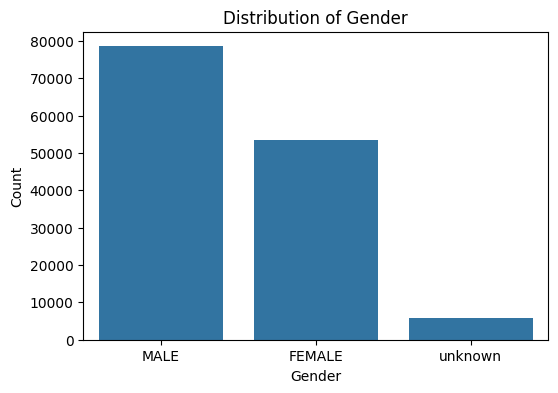

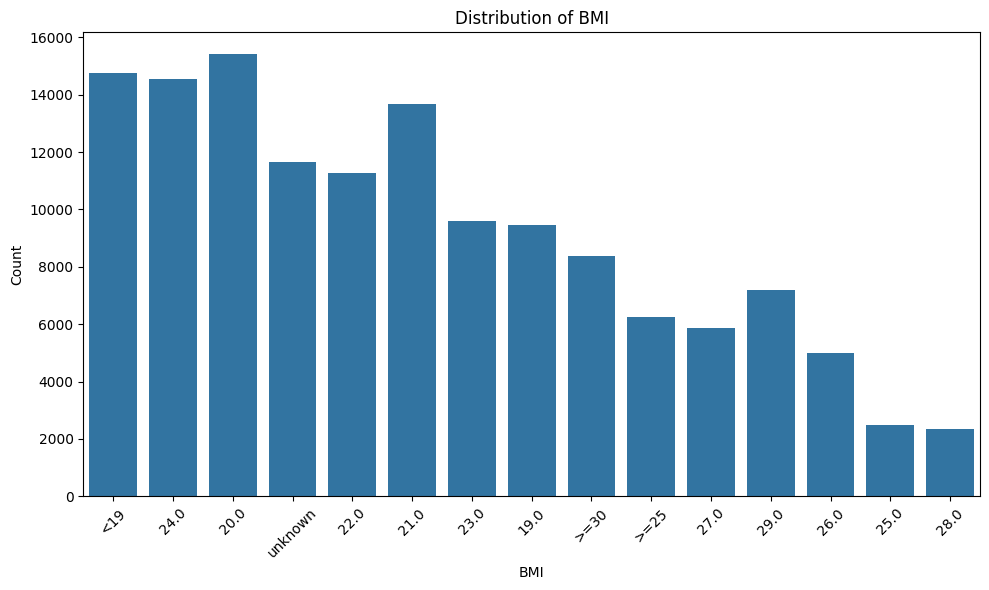

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a bar plot for gender distribution
plt.figure(figsize=(6, 4))
sns.countplot(data=df_final, x='gender')
plt.title('Distribution of Gender')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.show()

# Create a bar plot for bmi distribution
plt.figure(figsize=(10, 6))
sns.countplot(data=df_final, x='bmi', order=df_final['bmi'].value_counts().index)
plt.title('Distribution of BMI')
plt.xlabel('BMI')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

/tmp/ipython-input-480918538.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=mood_counts.index, y=mood_counts.values, palette='viridis')


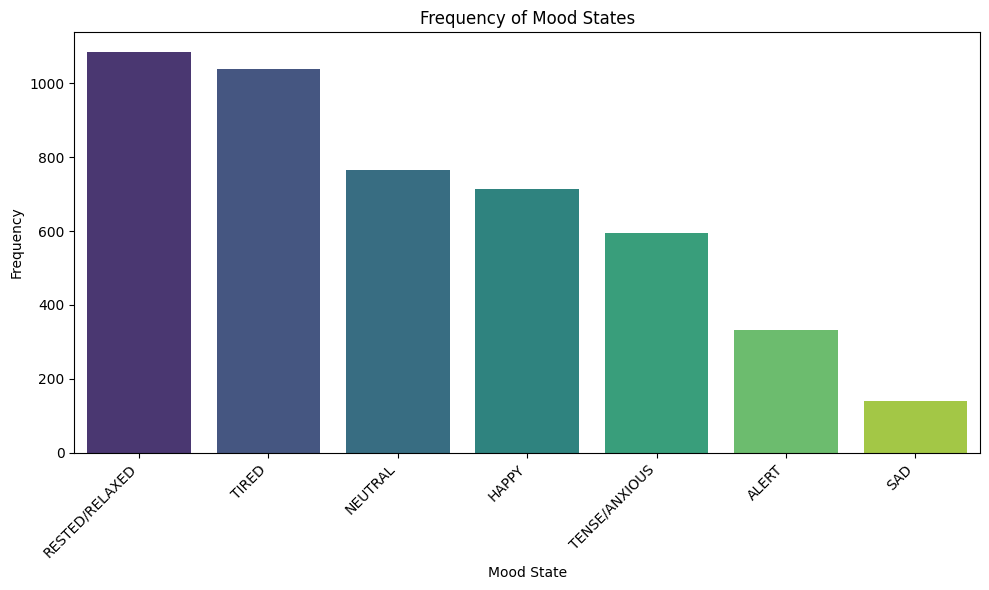

In [13]:
# Create a Series with the counts of each mood state
mood_counts = df_final[mood_cols].sum().sort_values(ascending=False)

# Create a bar chart to visualize the frequency of each mood state
plt.figure(figsize=(10, 6))
sns.barplot(x=mood_counts.index, y=mood_counts.values, palette='viridis')
plt.title('Frequency of Mood States')
plt.xlabel('Mood State')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Task
Analyze the columns "temp", "bpm", and "steps" in the dataframe `hourly_fitbit_sema_processed` using periodogram and autocorrelation techniques to find the most common periods across different `pid`s and present the results as percentages of `pid`s exhibiting these periods.

/tmp/ipython-input-1060069036.py:77: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_pid_resampled = df_pid.set_index('time').resample('8H').mean(numeric_only=True).reset_index()
/tmp/ipython-input-1060069036.py:32: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  time_series_filled = time_series.fillna(method='ffill')
/tmp/ipython-input-1060069036.py:77: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_pid_resampled = df_pid.set_index('time').resample('8H').mean(numeric_only=True).reset_index()
/tmp/ipython-input-1060069036.py:32: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  time_series_filled = time_series.fillna(method='ffill')
/tmp/ipython-input-1060069036.py:77: FutureWarning: 'H' is deprecated and wi


Most Frequent Dominant Periods (ACF only), Counts, and Percentages:

Column: temperature
  Method: acf
  Most frequent period(s): [3]
  Count of PIDs: 28
  Percentage of PIDs: 45.90%
--------------------

Column: bpm
  Method: acf
  Most frequent period(s): [3]
  Count of PIDs: 16
  Percentage of PIDs: 26.23%
--------------------

Column: steps
  Method: acf
  Most frequent period(s): [3]
  Count of PIDs: 11
  Percentage of PIDs: 18.03%
--------------------

Column: sleep_intensity
  Method: acf
  Most frequent period(s): [3]
  Count of PIDs: 10
  Percentage of PIDs: 16.39%
--------------------

Visualizing Frequency of Dominant Periods (ACF only) across PIDs:


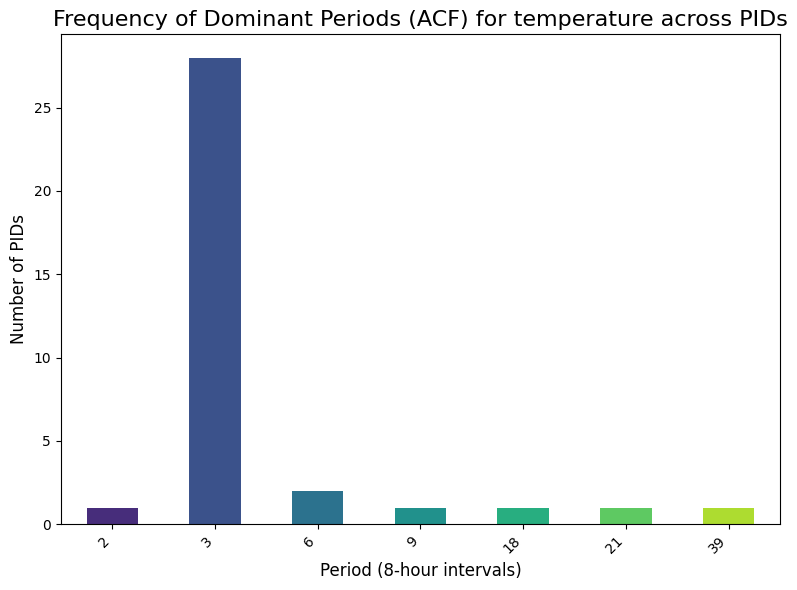

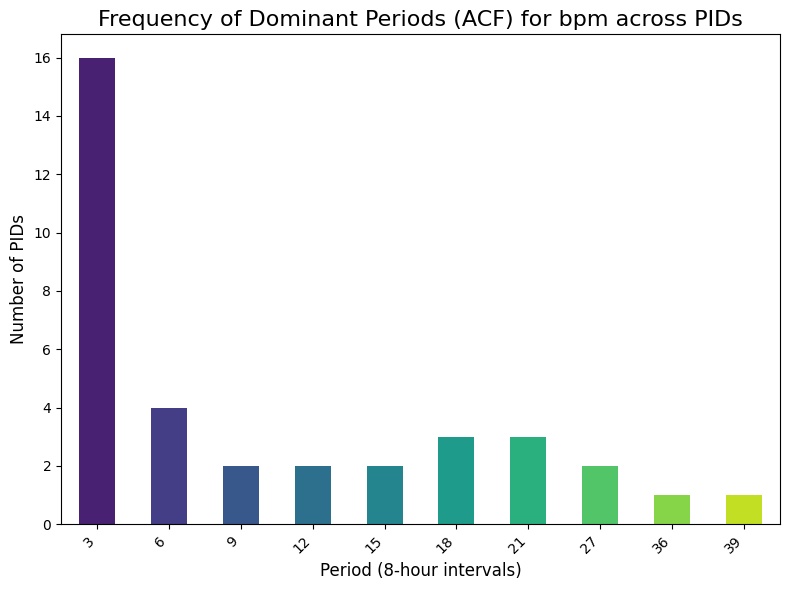

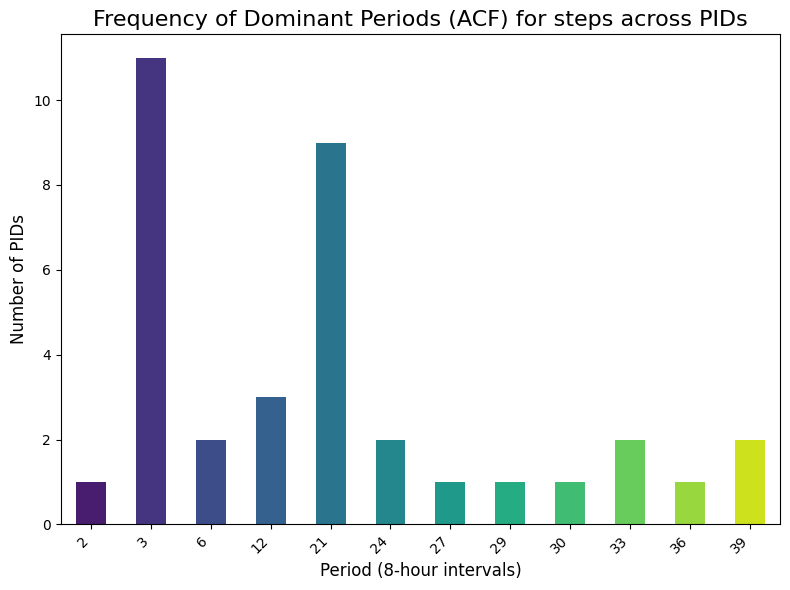

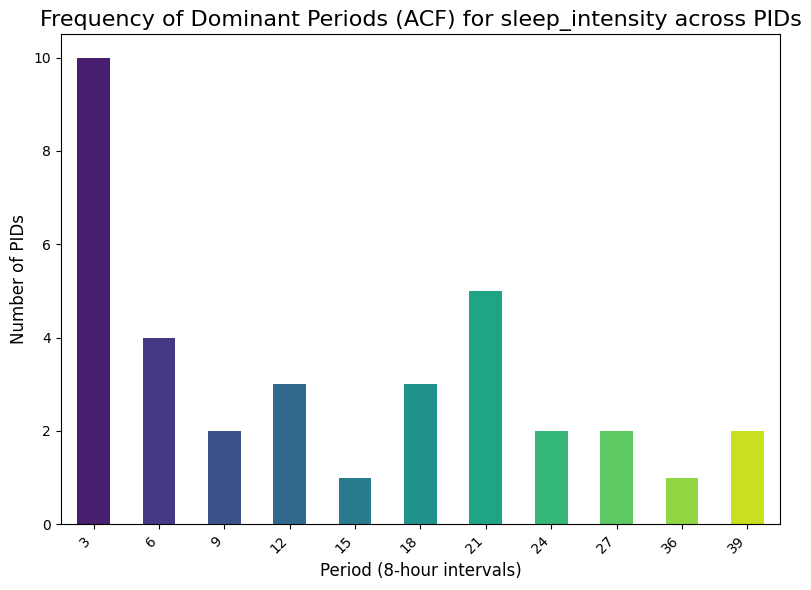


Task complete: Dominant periods analyzed using ACF with 8-hour intervals and a 3-month window, summarized, and visualized.


In [14]:
import pandas as pd
import numpy as np
from scipy.signal import periodogram
from statsmodels.tsa.stattools import acf
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.signal import find_peaks

# --- Use the processed data from the previous steps ---
# df_final is already available


# 1. Identify time series columns
time_series_cols = ['temperature', 'bpm', 'steps', 'sleep_intensity']

# 2. Define analysis function
def find_dominant_periods_acf(time_series: pd.Series, column_name: str):
    """
    Calculates the autocorrelation of a time series,
    identifies dominant periods, and returns them.

    Args:
        time_series: Pandas Series representing the time series data for a single pid.
        column_name: Name of the column being analyzed.

    Returns:
        A dictionary of dominant periods identified by method (acf).
    """
    dominant_periods = {}

    # Handle missing values using forward fill
    time_series_filled = time_series.fillna(method='ffill')

    # --- Autocorrelation Analysis (ACF) ---
    # Check if there is enough data for ACF after handling NaNs
    if len(time_series_filled.dropna()) > 1:
        try:
            # Calculate the autocorrelation function (ACF)
            # adjusted=True accounts for the mean of the time series
            autocorr = acf(time_series_filled.dropna(), nlags=min(len(time_series_filled.dropna()) // 2, 40), adjusted=True) # Limiting nlags for performance

            # Identify dominant period(s) from ACF
            # Look for the first significant peak after lag 0
            # A simple approach is to find the lag with the highest positive autocorrelation (excluding lag 0)
            if len(autocorr) > 1:
                 # Find peaks in ACF, considering only positive autocorrelations after lag 0
                peaks, _ = find_peaks(autocorr[1:], height=0.1) # Height threshold can be adjusted

                if len(peaks) > 0:
                    # Get the lag of the highest peak
                    dominant_lag_acf = peaks[np.argmax(autocorr[peaks + 1])] + 1
                    dominant_periods['acf'] = dominant_lag_acf
                elif np.max(autocorr[1:]) > 0.1: # If no peak found but there's a high positive correlation
                     dominant_periods['acf'] = np.argmax(autocorr[1:]) + 1


        except ValueError as e:
             print(f"ACF calculation failed for {column_name}: {e}")


    return dominant_periods


# 3. Iterate and analyze for each pid and column
unique_pids = df_final['pid'].unique()
dominant_periods_results = []

# Define time window for analysis (approximately 3 months)
# Assuming 'time' column is in datetime format
start_date = df_final['time'].min()
end_date = start_date + pd.Timedelta(days=90) # Approximately 3 months

for pid in unique_pids:
    df_pid = df_final[df_final['pid'] == pid].copy()

    # Resample to 8-hour intervals and select the time window, selecting only numeric columns
    df_pid_resampled = df_pid.set_index('time').resample('8H').mean(numeric_only=True).reset_index()
    df_pid_window = df_pid_resampled[(df_pid_resampled['time'] >= start_date) & (df_pid_resampled['time'] <= end_date)].copy()


    for col in time_series_cols:
        # Check if the column exists in the resampled data before proceeding
        if col in df_pid_window.columns:
            time_series_data = df_pid_window[col]
            # Apply the analysis function
            dominant_periods = find_dominant_periods_acf(time_series_data, col)

            dominant_periods_results.append({
                'pid': pid,
                'column': col,
                'dominant_periods': dominant_periods
            })


# 4. Aggregate dominant periods (only for ACF)
aggregated_periods = {}
for result in dominant_periods_results:
    column = result['column']
    dominant_periods = result['dominant_periods']
    # Only consider ACF results
    if 'acf' in dominant_periods:
        if column not in aggregated_periods:
            aggregated_periods[column] = {}
        if 'acf' not in aggregated_periods[column]:
            aggregated_periods[column]['acf'] = []
        # Filter out non-finite values before appending
        if np.isfinite(dominant_periods['acf']):
             aggregated_periods[column]['acf'].append(dominant_periods['acf'])


# 5. Determine common periods and their frequency (only for ACF)
period_frequencies = {}
for column, methods in aggregated_periods.items():
    period_frequencies[column] = {}
    if 'acf' in methods:
        periods = methods['acf']
        if periods: # Check if the list of periods is not empty
            period_counts = pd.Series(periods).value_counts()
            period_frequencies[column]['acf'] = period_counts
        else:
             period_frequencies[column]['acf'] = pd.Series(dtype=int) # Use empty Series if no periods


# 6. Calculate percentage of pids (only for ACF)
total_pids = df_final['pid'].nunique()
most_frequent_periods_with_percentage = {}

for column, methods in period_frequencies.items():
    most_frequent_periods_with_percentage[column] = {}
    if 'acf' in methods:
        counts = methods['acf']
        if not counts.empty:
            max_count = counts.max()
            most_frequent = counts[counts == max_count].index.tolist()
            percentage = (max_count / total_pids) * 100 if total_pids > 0 else 0
            most_frequent_periods_with_percentage[column]['acf'] = {
                'periods': most_frequent,
                'count': max_count,
                'percentage': percentage
            }
        else:
             most_frequent_periods_with_percentage[column]['acf'] = {
                'periods': [],
                'count': 0,
                'percentage': 0.0
            }


# 7. Present results
print("\nMost Frequent Dominant Periods (ACF only), Counts, and Percentages:")
for col, methods in most_frequent_periods_with_percentage.items():
    print(f"\nColumn: {col}")
    for method, data in methods.items():
        print(f"  Method: {method}")
        print(f"  Most frequent period(s): {data['periods']}")
        print(f"  Count of PIDs: {data['count']}")
        print(f"  Percentage of PIDs: {data['percentage']:.2f}%")
    print("-" * 20)

# 8. Visualize the frequency of dominant periods across PIDs (ACF only)
print("\nVisualizing Frequency of Dominant Periods (ACF only) across PIDs:")

for column, methods in period_frequencies.items():
    if 'acf' in methods:
        counts = methods['acf']
        if not counts.empty:
            plt.figure(figsize=(8, 6))
            # Sort periods for better visualization
            counts_sorted = counts.sort_index()
            counts_sorted.plot(kind='bar', color=sns.color_palette("viridis", len(counts_sorted)))
            plt.title(f'Frequency of Dominant Periods (ACF) for {column} across PIDs', fontsize=16)
            plt.xlabel('Period (8-hour intervals)', fontsize=12)
            plt.ylabel('Number of PIDs', fontsize=12)
            plt.xticks(rotation=45, ha='right') # Rotate x-axis labels for readability

            plt.tight_layout() # Adjust layout
            plt.show()
        else:
             plt.figure(figsize=(8, 6))
             plt.title(f'Frequency of Dominant Periods (ACF) for {column} across PIDs - No Data', fontsize=16)
             plt.text(0.5, 0.5, "No dominant periods found", horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)
             plt.xlabel('Period (8-hour intervals)', fontsize=12)
             plt.ylabel('Number of PIDs', fontsize=12)
             plt.show()


# 9. Finish task - Summary is included in the print statements above and visualizations
print("\nTask complete: Dominant periods analyzed using ACF with 8-hour intervals and a 3-month window, summarized, and visualized.")

Its time to predict stress score with 16/18 transformer model +lstm, GRU

Adding gender/ processing